<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/mini_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import math

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps=100):
        super().__init__()
        self.timesteps = timesteps

        # Improved time embedding with sinusoidal positional encoding
        time_dim = hidden_dim * 4
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, hidden_dim),
        )

        # Enhanced network architecture with residual connections
        self.net = nn.Sequential(
            ResidualBlock(input_dim + hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            ResidualBlock(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, input_dim)
        )

        # Beta schedule using cosine schedule instead of linear
        self.register_buffer('betas', get_cosine_schedule(timesteps))
        alphas = 1. - self.betas
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))

    def forward(self, x_noisy, t):
        t_emb = self.time_embed(t)
        t_emb = t_emb.expand(x_noisy.shape[0], -1)
        x = torch.cat([x_noisy, t_emb], dim=1)
        return self.net(x)

    def noising_process(self, x, t): #cumprod is equivalent to sequentially adding up gaussian noise for timestep t (the math for it is quite interesting)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        noise = torch.randn_like(x)
        #print(x.shape) [128, 784]
        return (sqrt_alphas_cumprod_t * x +
                sqrt_one_minus_alphas_cumprod_t * noise), noise

    @torch.no_grad()
    def sample(self, n_samples, device):
        # Start with random noise
        x = torch.randn(n_samples, 784).to(device)

        for t in reversed(range(self.timesteps)):
            # Create batch of same timestep
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)

            # Predict noise
            predicted_noise = self(x, t_batch)

            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]

            # Only add noise if we're not in the last step
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise
            ) + torch.sqrt(1 - alpha_t) * noise

        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )
        self.proj = nn.Linear(in_channels, out_channels) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.net(x) + self.proj(x)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

def get_cosine_schedule(timesteps):
    """
    Create a cosine schedule for the noise variance (beta).
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + 0.008) / (1 + 0.008) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def train_step(model, optimizer, x_real, device):
    optimizer.zero_grad()
    batch_size = x_real.shape[0]

    # Sample random timesteps for each item in the batch
    t = torch.randint(0, model.timesteps, (batch_size,), device=device)

    # Add noise to the real data
    x_noised, noise_added = model.noising_process(x_real, t)

    # Predict the noise
    predicted_noise = model(x_noised, t)

    # Loss is MSE between predicted and actual noise
    loss = F.mse_loss(predicted_noise, noise_added)

    loss.backward()
    optimizer.step()

    return loss.item()



In [4]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.cuda import amp  # for mixed precision training
import gc  # for garbage collection

def train_diffusion_colab(model, dataloader, num_epochs=20, device='cuda'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scaler = amp.GradScaler()  # for mixed precision training

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        # Using tqdm for progress bar
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch, _ in progress_bar:
            # Clear GPU memory
            if device == 'cuda':
                torch.cuda.empty_cache()

            batch = batch.view(-1, 784).to(device)
            optimizer.zero_grad()

            # Mixed precision training
            with amp.autocast():
                # Sample random timesteps
                t = torch.randint(0, model.timesteps, (batch.shape[0],), device=device)

                # Add noise
                x_noised, noise_added = model.noising_process(batch, t)

                # Predict noise
                predicted_noise = model(x_noised, t)
                loss = F.mse_loss(predicted_noise, noise_added)

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update progress bar
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        # Step the scheduler
        scheduler.step()

        # Calculate average loss
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Generate and save samples every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_samples(model, device, epoch)

        # Clear memory
        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()

def generate_samples(model, device, epoch, n_samples=16):
    model.eval()
    with torch.no_grad():
        samples = model.sample(n_samples=n_samples, device=device)
        samples = samples.view(-1, 1, 28, 28)
        # Save or display samples here (you can use torchvision.utils.save_image)
        # For Colab, you might want to display them inline
        return samples

# Usage in Colab:

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model and move to device
model = DiffusionModel(input_dim=784, hidden_dim=256).to(device)

# Create dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = MNIST('./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train model
train_diffusion_colab(model, dataloader, num_epochs=20, device=device)


Using device: cuda


<ipython-input-4-342eb9cdb109>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # for mixed precision training


Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

<ipython-input-4-342eb9cdb109>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1, Average Loss: 0.9986


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Average Loss: 0.8313


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Average Loss: 0.7616


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Average Loss: 0.7462


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, Average Loss: 0.7388


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, Average Loss: 0.7333


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, Average Loss: 0.7291


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, Average Loss: 0.7264


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, Average Loss: 0.7233


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, Average Loss: 0.7217


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, Average Loss: 0.7192


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, Average Loss: 0.7186


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, Average Loss: 0.7170


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, Average Loss: 0.7160


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, Average Loss: 0.7153


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, Average Loss: 0.7148


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, Average Loss: 0.7142


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, Average Loss: 0.7136


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, Average Loss: 0.7137


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, Average Loss: 0.7137


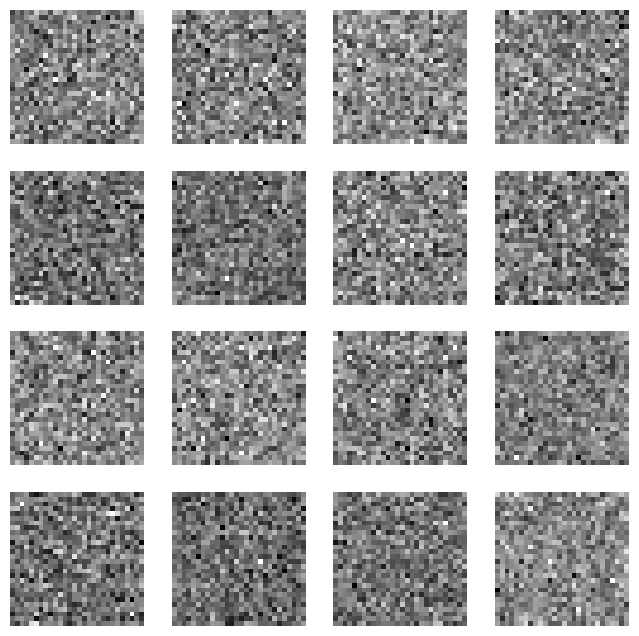

In [5]:
import torch
import matplotlib.pyplot as plt

# Create dummy data for 16 grayscale images of size 28x28
data = torch.randn(16, 1, 28, 28)

# Plot the images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i, 0], cmap='gray')
    ax.axis('off')

plt.show()


In [ ]:
print("alphas:", model.alphas.shape)
print("alphas_cumprod:", model.alphas_cumprod.shape)
print("sqrt_alphas_cumprod:", model.sqrt_alphas_cumprod.shape)
print("sqrt_one_minus_alphas_cumprod:", model.sqrt_one_minus_alphas_cumprod.shape)

alphas: torch.Size([100])
alphas_cumprod: torch.Size([100])
sqrt_alphas_cumprod: torch.Size([100])
sqrt_one_minus_alphas_cumprod: torch.Size([100])


In [ ]:
batch.shape

torch.Size([96, 784])

In [ ]:
%whos


Variable         Type              Data/Info
--------------------------------------------
DataLoader       type              <class 'torch.utils.data.dataloader.DataLoader'>
DiffusionModel   type              <class '__main__.DiffusionModel'>
F                module            <module 'torch.nn.functio<...>/torch/nn/functional.py'>
MNIST            type              <class 'torchvision.datasets.mnist.MNIST'>
avg_loss         float             1.0049076886065225
batch            Tensor            tensor([[-1., -1., -1.,  <...>.,  ..., -1., -1., -1.]])
dataloader       DataLoader        <torch.utils.data.dataloa<...>object at 0x7c30996ed8d0>
dataset          MNIST             Dataset MNIST\n    Number<...>std=(0.5,))\n           )
device           device            cpu
epoch            int               0
loss             float             0.9948086142539978
model            DiffusionModel    DiffusionModel(\n  (time_<...>s=784, bias=True)\n  )\n)
nn               module            <modu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps=100):
        super().__init__()
        self.timesteps = timesteps

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Main network
        self.net = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        # Setup noise schedule - using beta schedule instead of alpha directly
        betas = torch.linspace(0.0001, 0.02, timesteps)
        alphas = 1. - betas
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))

    def get_time_embedding(self, t):
        # Convert t to float and reshape
        t_float = t.float().view(-1, 1)
        return self.time_embed(t_float)

    def forward(self, x_noisy, t):
        # Embed time
        #print(t.shape) [128]
        t_emb = self.get_time_embedding(t) #[128, 256]

        # Ensure t_emb has the same batch size as x_noisy
        t_emb = t_emb.expand(x_noisy.shape[0], -1) #[128, 256]

        # Concatenate input with time embedding
        x = torch.cat([x_noisy, t_emb], dim=1) #[128, 1040]
        #print(x_noisy.shape) [128, 784]

        # Predict noise
        return self.net(x)

    def noising_process(self, x, t): #cumprod is equivalent to sequentially adding up gaussian noise for timestep t (the math for it is quite interesting)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        noise = torch.randn_like(x)
        #print(x.shape) [128, 784]
        return (sqrt_alphas_cumprod_t * x +
                sqrt_one_minus_alphas_cumprod_t * noise), noise

    @torch.no_grad()
    def sample(self, n_samples, device):
        # Start with random noise
        x = torch.randn(n_samples, 784).to(device)

        for t in reversed(range(self.timesteps)):
            # Create batch of same timestep
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)

            # Predict noise
            predicted_noise = self(x, t_batch)

            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]

            # Only add noise if we're not in the last step
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise
            ) + torch.sqrt(1 - alpha_t) * noise

        return x

def train_step(model, optimizer, x_real, device):
    optimizer.zero_grad()
    batch_size = x_real.shape[0]

    # Sample random timesteps for each item in the batch
    t = torch.randint(0, model.timesteps, (batch_size,), device=device)

    # Add noise to the real data
    x_noised, noise_added = model.noising_process(x_real, t)

    # Predict the noise
    predicted_noise = model(x_noised, t)

    # Loss is MSE between predicted and actual noise
    loss = F.mse_loss(predicted_noise, noise_added)

    loss.backward()
    optimizer.step()

    return loss.item()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
model = DiffusionModel(input_dim=784, hidden_dim=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Setup data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

dataset = MNIST('./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for batch, _ in dataloader:
        batch = batch.view(-1, 784).to(device)
        loss = train_step(model, optimizer, batch, device)
        total_loss += loss
        num_batches += 1

    avg_loss = total_loss / num_batches
    #if epoch % 10 == 0:
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

    # Generate samples
    samples = model.sample(n_samples=16, device=device)
    samples = samples.view(-1, 1, 28, 28)
    #print(f"Generated samples shape: {samples.shape}")
    #break